In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset
from pyg_classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from pyg_classifier.train import pool_train_loop
from pyg_classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = False
k = 0

#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

/home/milan/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OSError: /home/milan/anaconda3/envs/torch/lib/python3.9/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs

TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that i0/m0/other is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?

In [2]:
#Training
model = DMoN_CG_Classifier(training_dataset.num_node_features)

parent_dir = "pyg_model_data/"


epoch_losses, val_losses, mae_losses, learning_rates = pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=50,
    sched_T0=10,
    vectorize=vectorize,
    k=k,
    burn_in=5)

AttributeError: module 'torch_geometric.nn' has no attribute 'DMoNPooling'

In [3]:
#get training run data

file = "loss_data/2022-04-01_pyg_diff_b64_vec_loss_data.txt"

file_lines = []
with open(file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss 0.1558 in epoch 3993
Minimum Validation Loss (after 50 epochs) 13.1296 in epoch 3003
Minimum MAE (after 50 epochs) 13.3740 in epoch 3003


Validation Loss at 47 is 17.4614
5 before select
17.8627, 17.9023, 17.8741, 18.1131, 17.8377
5 after select
18.5085, 17.5412
MAE at 47 is 15.2635


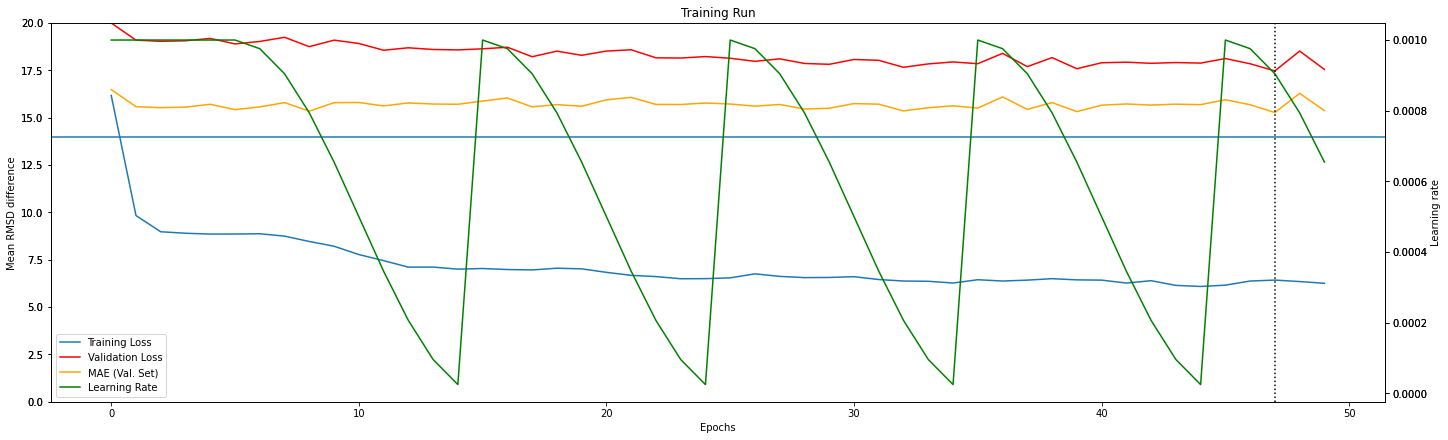

In [10]:
#plot the training run
path = ""

select = 47
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=14)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2)
plt.draw()

Test Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[36.1110]], device='cuda:0') tensor([[0.1475]], device='cuda:0') 35.46349334716797
Mean Test loss: 	 10.4419
Std. Dev. of Test loss:  8.6483
Min loss: 		 0.0000
First Quantile: 	 2.9252
Median: 		 8.8984
Third Quantile: 	 17.7555
Max Loss: 		 35.4635
LinregressResult(slope=0.3845631235022494, intercept=10.249639495465399, rvalue=0.3787721737713962, pvalue=7.027708957955656e-11, stderr=0.05666239516191572, intercept_stderr=1.195995496994138)


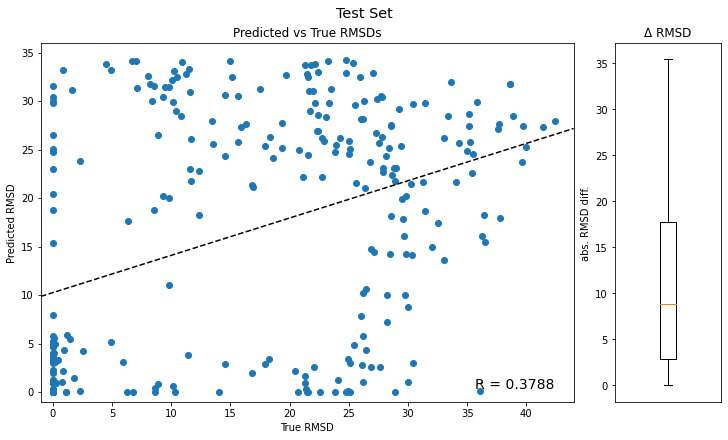

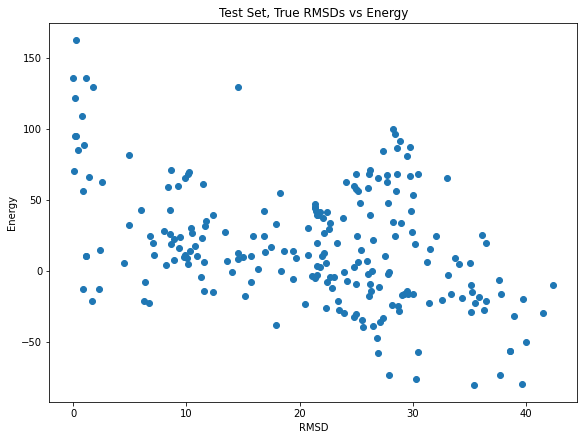

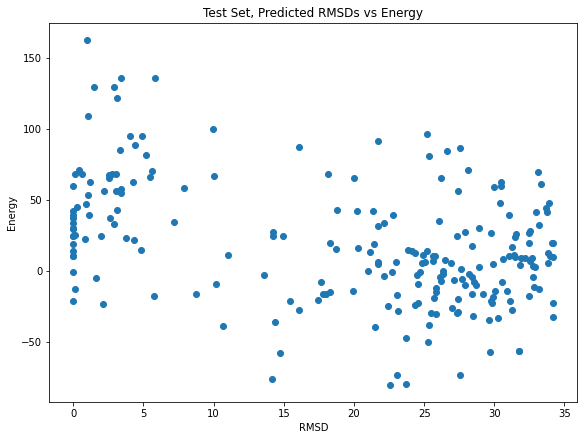

5S and tRNA Test Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[0.]], device='cuda:0') tensor([[33.0485]], device='cuda:0') 32.54848098754883
Mean Test loss: 	 5.0921
Std. Dev. of Test loss:  5.3611
Min loss: 		 0.0000
First Quantile: 	 1.4711
Median: 		 3.5442
Third Quantile: 	 7.0227
Max Loss: 		 32.5485
LinregressResult(slope=0.6785614601899297, intercept=2.9384787527019434, rvalue=0.6953469013068334, pvalue=2.841092610139635e-157, stderr=0.02133078839050238, intercept_stderr=0.45156327300446103)


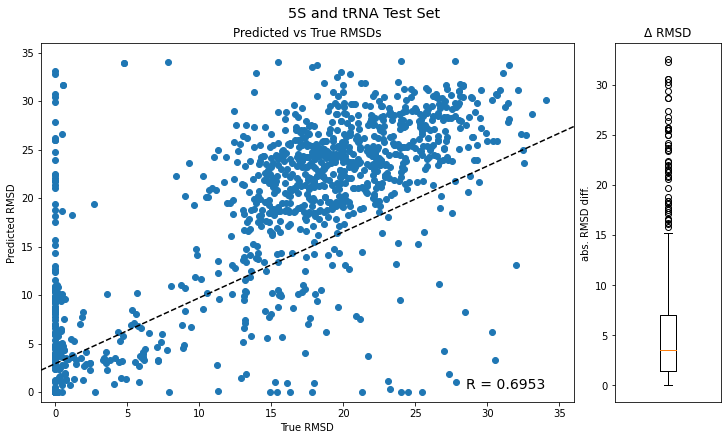

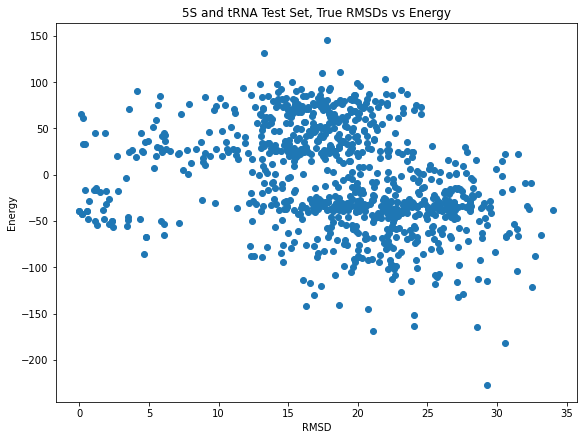

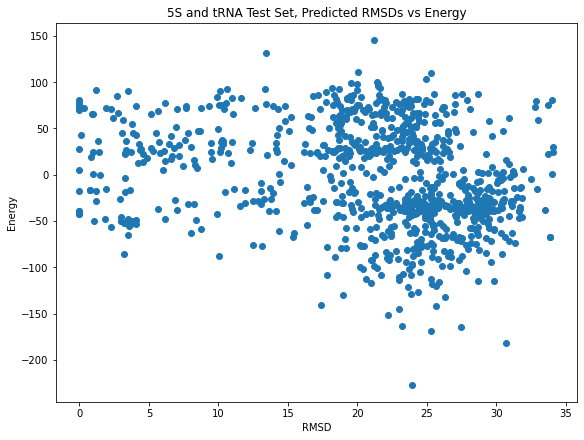

Training Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[22.5640]], device='cuda:0') tensor([[31.4997]], device='cuda:0') 8.43572998046875
Mean Test loss: 	 1.3525
Std. Dev. of Test loss:  1.5434
Min loss: 		 0.0000
First Quantile: 	 0.1333
Median: 		 0.7388
Third Quantile: 	 2.2162
Max Loss: 		 8.4357
LinregressResult(slope=0.9391348050809862, intercept=0.15046382352575804, rvalue=0.9734717056720843, pvalue=0.0, stderr=0.008017521181528068, intercept_stderr=0.16964118416020899)


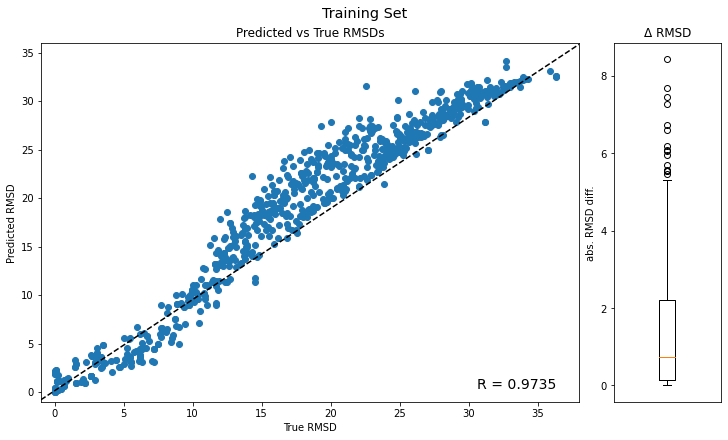

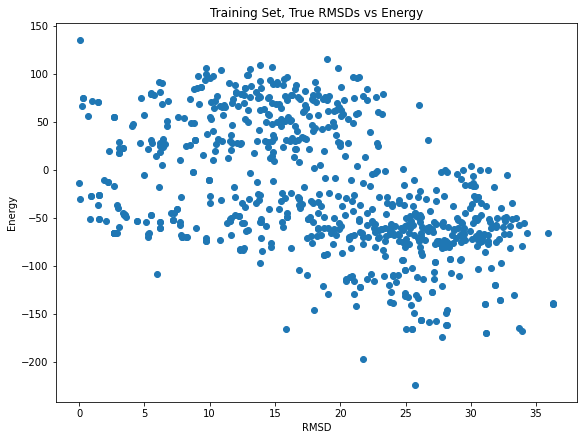

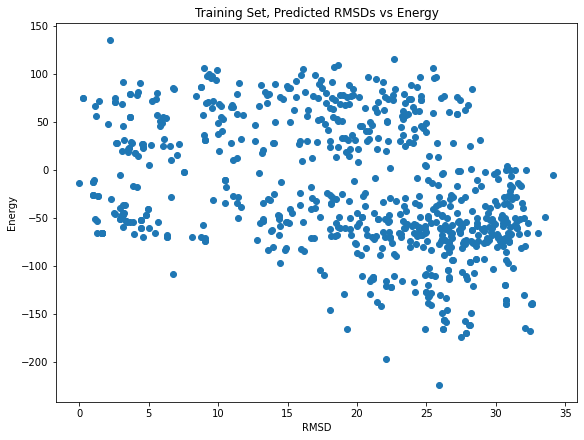

Validation Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[60.2560]], device='cuda:0') tensor([[0.]], device='cuda:0') 59.75600051879883
Mean Test loss: 	 13.7700
Std. Dev. of Test loss:  9.8586
Min loss: 		 0.0000
First Quantile: 	 6.1322
Median: 		 12.5583
Third Quantile: 	 20.1713
Max Loss: 		 59.7560
LinregressResult(slope=0.22583715805889337, intercept=18.32351193657623, rvalue=0.12227486913972052, pvalue=0.014904569086470988, stderr=0.0923504397850152, intercept_stderr=2.166572901772878)


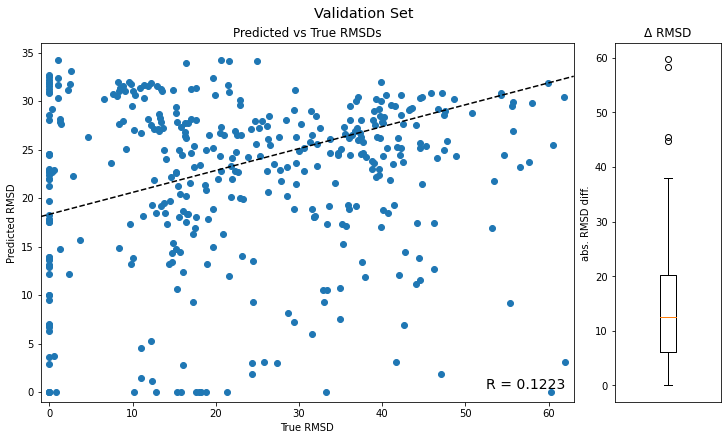

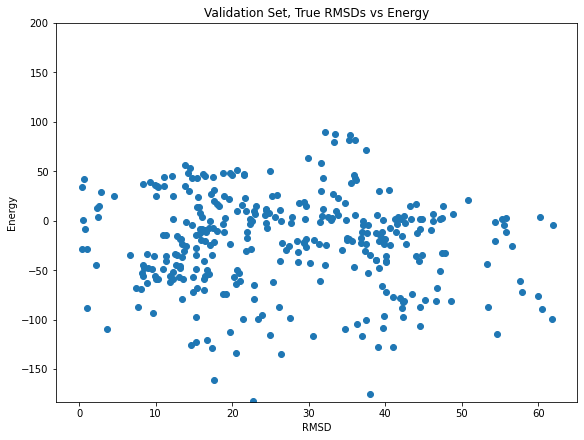

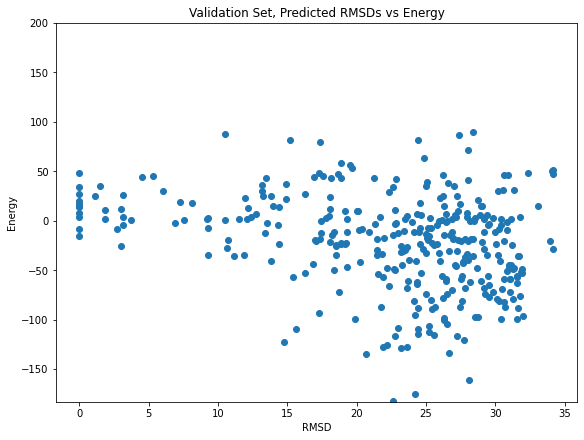

LinregressResult(slope=0.3526826178761766, intercept=13.411844386476291, rvalue=0.307949262067113, pvalue=4.062747731092684e-34, stderr=0.02823722119073505, intercept_stderr=0.6432821085681224)


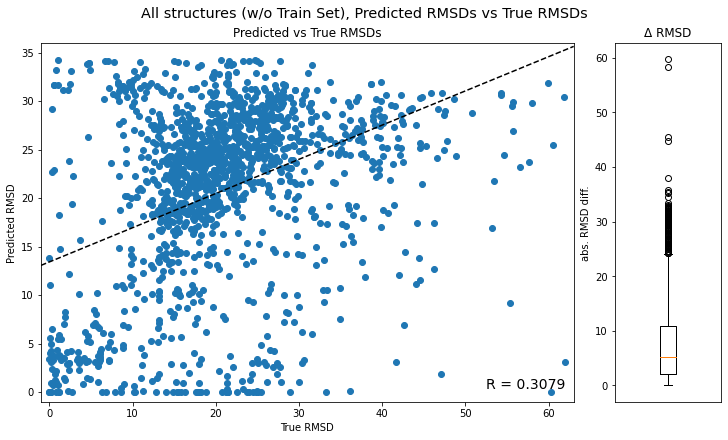

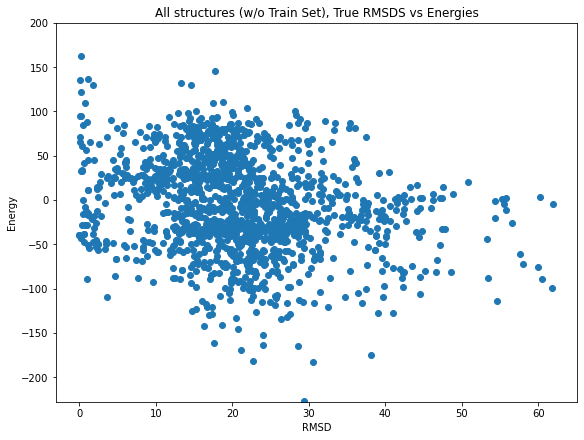

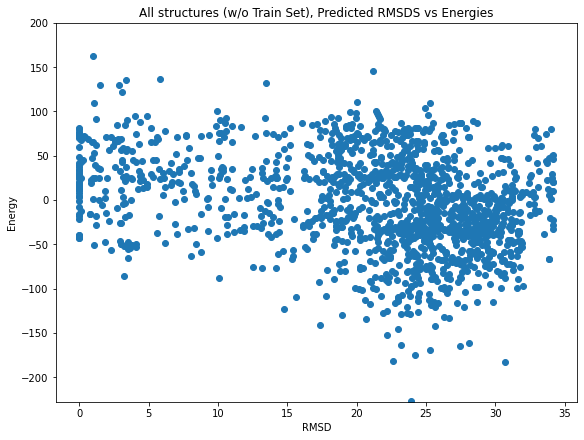

In [24]:
#Test
from pyg_classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    num_node_feats = training_dataset.num_node_features
    model = Diff_CG_Classifier(num_node_feats).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load("pyg_diff_model_data/model_epoch877.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9312572605528491, intercept=1.7384231026290227, rvalue=0.9456053967184174, pvalue=3.889894079425344e-136, stderr=0.01931962403363573, intercept_stderr=0.40778691549873497)


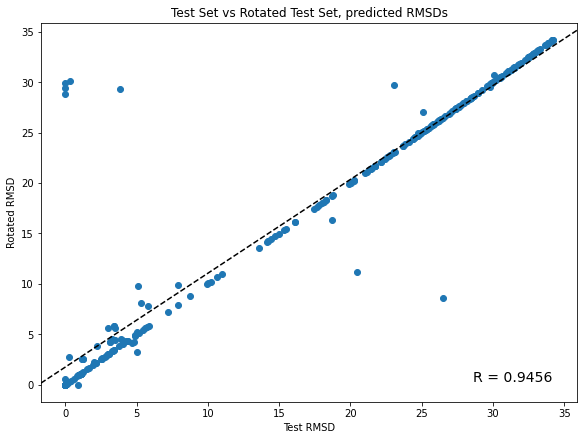

LinregressResult(slope=0.9080704982255864, intercept=1.518085431231679, rvalue=0.8936383103570963, pvalue=1.1006093898449704e-97, stderr=0.02749999217457044, intercept_stderr=0.37285287122553173)


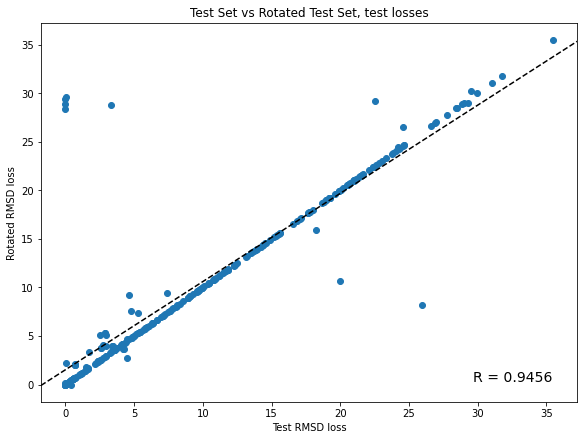

LinregressResult(slope=0.9670513823854341, intercept=0.7076137680821759, rvalue=0.965249222813909, pvalue=0.0, stderr=0.007963212773057725, intercept_stderr=0.16857766143486583)


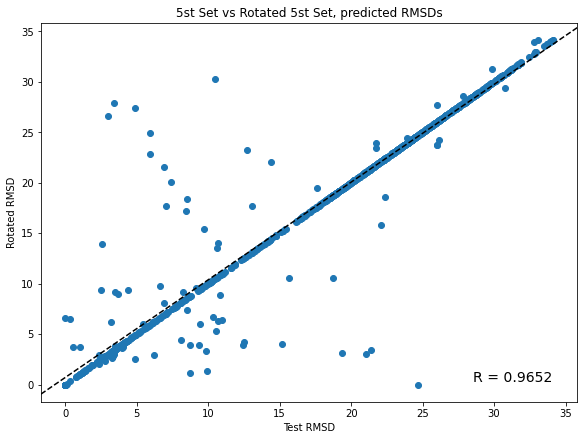

LinregressResult(slope=0.9416248917139592, intercept=0.3755509451737993, rvalue=0.9041042535928252, pvalue=0.0, stderr=0.013536039235739372, intercept_stderr=0.1000852009942696)


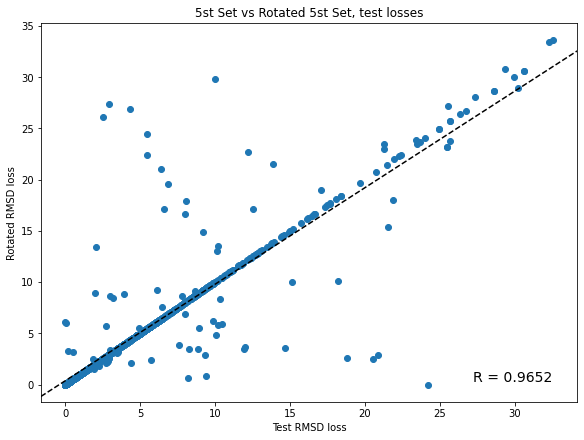

In [25]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")